In [44]:
# Example of AR-GARCH method for synthesising day-ahead forecasts for onshore wind

# Authors: Zappa, W., Walther, T. & van den Broek, M (2020). Synthesising forecasts of load and variable renewable generation 
# for day-ahead, intraday, and balancing market modelling. Submitted to Applied Energy. 

# The real-time and day-ahead forecast data for onshore wind is taken from the ENTSO-E Transparency Platform
# https://transparency.entsoe.eu/


In [45]:
#Import libraries

import pandas as pd
import numpy as np
from scipy import stats, random
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from arch import arch_model 
import datetime as dt
from dateutil.relativedelta import *
%matplotlib inline
import seaborn as sns   
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import statsmodels.stats.api as sms

# Define functions

#Here just defining some functions to calculate and compare forecast metrics between historical and modelled forecasts
def get_maape(y, y_hat):
    '''Mean Arctangent Absolute Percent Error
    See article by Kim et al.: DOI: 10.1016/j.ijforecast.2015.12.003
    
    '''
    #This metric is an alternative to MAPE, and is better at dealing with 0 values and small values
    t = len(y)
    maape = np.arctan(abs((y - y_hat)/y)).sum()/t
    
    return maape

def get_mane(y, y_hat,ynorm=1):
    '''Mean Absolute Normalised Error
    This is my metric, similar to mean absolute percentage error, but expressed as a
    percentage of a normalised value, which differs per parameter:
        Load: peak load
        vRES: installed capacity 
    
    '''
    t = len(y)
    numerator = sum(abs(y - y_hat))*(1/t)
    mane = numerator/ynorm
    
    
    return mane

def get_nRMSE(y, y_hat,ynorm=1):
    '''Normalised Root Mean Square Error
    My metric, it's just the RMSE normalised to a certain value. e.g.
        Load: peak load
        vRES: installed capacity 
    '''
    mse = np.mean((y - y_hat)**2)
    rmse=np.sqrt(mse)
    nrmse = rmse/ynorm
    return nrmse

def get_nMBE(y, y_hat,ynorm=1):
    '''Normalised Mean Bias Error. The difference with mean absolute error is that the latter takes the absolute value, this doesn't.
    It's the MBE normalised to a certain value. e.g.
        Load: peak load
        vRES: installed capacity 
    '''
    mbe = np.mean((y - y_hat))
    nmbe = mbe/ynorm
    return nmbe

def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput



In [46]:
# STEP 1: Calculate normalised historical real-time and day-ahead forecast errors
#-----------------------------------------------------------------------------------------------------

# Note: this step has already been applied to the raw data

# Set file path for historical real-time and forecast series (change as required)
data = pd.read_excel("O://Balancing Market Paper//Selected data_v1.xlsx", sheet_name = "Onshore Wind", index_col = 0)

# Set folder path for output files (change as required)
outputFolder = "O://Balancing Market Paper//Script outputs//Figures from Jupyter//"

#Calculate error as real time - forecast.
data['Error']=data['Real time']-data['DA forecast']

# compute the deviation as absolute error 
data['dev'] = abs(data['Error'])


#Parameter name
param = "ONWIND"

In [47]:
# STEP 2: Calculate total daily absolute error and fit AR-GARCH model
#---------------------------------------------------------------------------------------------------------------------------

# compute the total daily absolute error
days = int(len(data['dev'])/24)
dailyabsdev = pd.DataFrame([sum(data['dev'].iloc[((i-1)*24):((i-1)*24+24)]) for i in range(1,days+1)],
                        index = pd.date_range(start='1/1/2017', periods=days))

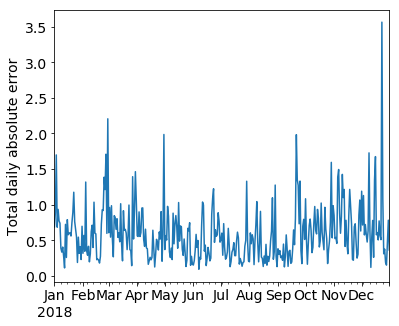

In [48]:
#Plot the total daily absolute error for year 2018 (just as visualisation)

nSim=365 #
timeframe = pd.date_range("2018/01/01", periods = 365)
start = timeframe[0].strftime("%Y-%m-%d")
end = timeframe[nSim-1].strftime("%Y-%m-%d") 


dailyabsdev[start:end].plot(legend=None,figsize=(6,5),fontsize=14)
pyplot.ylabel("Total daily absolute error",fontsize=14)

pyplot.savefig(outputFolder+"Total historical (2018) daily deviation for ONWIND.png",bbox_inches='tight',dpi=400)

In [49]:
#Test the total daily absolute error series for stationarity

test_stationarity(dailyabsdev[start:end][0]) 

Test Statistic                  -3.786736
p-value                          0.003046
#Lags Used                      17.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64

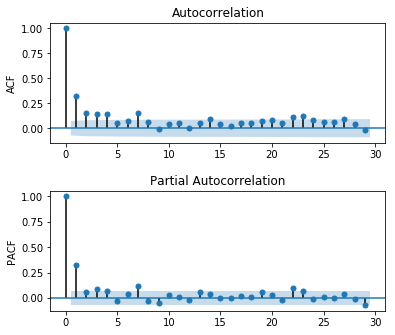

In [50]:
#Plot the ACF and PCF values of the total daily error series to help determine order of AR(a)-GARCH(p,q) model

pyplot.subplot(211)
plot_acf(dailyabsdev, ax=pyplot.gca()) 
pyplot.ylabel("ACF")
pyplot.subplot(212)
plot_pacf(dailyabsdev, ax=pyplot.gca())    
pyplot.ylabel("PACF")

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots        

pyplot.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
        
pyplot.savefig(outputFolder+"ACF and PCF for total daily deviation - ONWIND.png",bbox_inches='tight',dpi=400)

In [51]:
# Fit a AR(a)-GARCH(p,q) model with residuals modelled with Skewed Student's T Model

#Note: the series is scaled by 100 to allow for better model fitting

gmod = arch_model(dailyabsdev[0]*100, mean='AR', lags=1, vol='GARCH', p=1,q=1,o=0,rescale=False, dist='SkewStudent')
gmod_fit = gmod.fit(disp='off')
print(gmod_fit.summary)

<bound method ARCHModelResult.summary of                                  AR - GARCH Model Results                                
Dep. Variable:                                 0   R-squared:                       0.072
Mean Model:                                   AR   Adj. R-squared:                  0.071
Vol Model:                                 GARCH   Log-Likelihood:               -3371.45
Distribution:      Standardized Skew Student's t   AIC:                           6756.90
Method:                       Maximum Likelihood   BIC:                           6789.04
                                                   No. Observations:                  729
Date:                           Tue, Jan 07 2020   Df Residuals:                      722
Time:                                   22:58:19   Df Model:                            7
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
---

In [52]:
# STEP 3: Remove daily error volatility from hourly errors
#------------------------------------------------------------------------------------------------------------------

values=0

dailyvola = gmod_fit.conditional_volatility/24

for v in dailyvola:
    day = np.asarray([1]*24)*v
    values=np.append(values,day)
values[1:25] = values[25:49]
data['shours'] = data['Error'] / pd.Series(values[1:len(values)],index=data[0:len(data)].index)

In [53]:
# STEP 4: Bin hours errors based on normalised generation level
#------------------------------------------------------------------------------------------------------------------
# Using 20 bins

bins = np.linspace(0,1,21)
cluster = [data.loc[(data['Real time']>bins[i-1]) & (data['Real time']<bins[i])]['shours'] for i in range(1,len(bins))]
powerdist = [[bins[i],cluster[i].mean(), cluster[i].std()] for i in range(0,len(bins)-1)]

#Get the first non-NAN std dev
for i in range(0,len(bins)-1):  
    sd = powerdist[i][2]
    if np.isnan(sd):
        continue
    else:
        firstsd=sd
        break
#Get the last non-NAN std dev        
for i in range(len(bins)-2,-1,-1):  
    sd = powerdist[i][2]
    if np.isnan(sd):
        continue
    else:
        lastsd=sd
        break
        
validVals=0 #count number of valid std dev values encountered
for i in range(0,len(bins)-1):
    if np.isnan(powerdist[i][2])==False:
        mu = powerdist[i][1]
        sd = powerdist[i][2]
        validVals=validVals+1
        lastsd=sd                  #update last valid sd
    if np.isnan(powerdist[i][1]):
        powerdist[i][1] = 0
    if np.isnan(powerdist[i][2]):
        if validVals==0:
            powerdist[i][2] = firstsd #if no valid vals encountered yet, at start, so replace with first sd
        else:
            powerdist[i][2] = lastsd #if some valid vals encountered yet, at end, so replace with last sd
            
    else:
        lastsd = sd

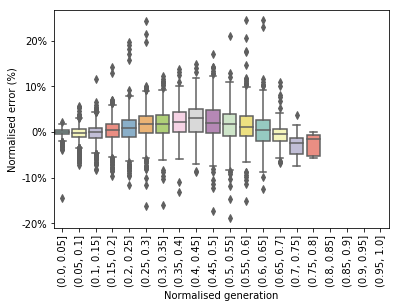

In [54]:
# Now just plotting the bins (just for visualisation)

data['powerBin'] = pd.cut(data['Real time'], bins)

ax = sns.boxplot(x="powerBin", y="shours", data=data, palette="Set3")

ax.set(ylabel='Normalised error (%)')
ax.set(xlabel='Normalised generation')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=0))


powerdistDF = pd.DataFrame.from_records(powerdist)
powerdistDF.columns=['Bin','Mean','Std deviation']

powerdistDF['To']=powerdistDF['Bin']+0.05

powerdistDF['Bin']="("+round(powerdistDF['Bin'],2).map(str) +"," +round(powerdistDF['To'],2).map(str)+"]"
powerdistDF=powerdistDF.drop('To',axis=1)

powerdistDF.to_csv(outputFolder+ "Level-binned error distributions - ONWIND.csv")



levelbinnedplot = ax.get_figure()
levelbinnedplot.savefig(outputFolder+"Level binned errors (devolatilised) - ONWIND.png",bbox_inches='tight',dpi=400)



(0.0023505006017617578, 0.0185583830178157)
(0.004258534204237051, 0.02630703670323918)
(3.5390099152693466, 0.0025567580234884695, 0.018123182381344506)


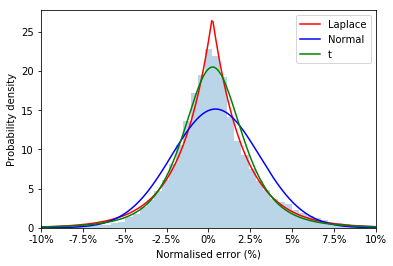

In [55]:
# STEP 5: To adjust for the overall common daily error component which is not encapsulated 
# by the generation (or load) level bins, identify an appropriate probability distribution for the hourly 
# errors and fit the parameters
#------------------------------------------------------------------------------------------------------------------

# Note: Here just testing normal, laplace and t-distributions, could try others

y = data['shours']

# fit laplace, normal, and t dist to y
parameters1 = scipy.stats.laplace.fit(y)
parameters2 = scipy.stats.norm.fit(y)
parameters3 = scipy.stats.t.fit(y)
x = np.linspace(-.4,.4,1000)
pdf_fitted1 = scipy.stats.laplace.pdf(x, loc=parameters1[0], scale=parameters1[1])
pdf_fitted2 = scipy.stats.norm.pdf(x, loc=parameters2[0], scale=parameters2[1])
pdf_fitted3 = scipy.stats.t.pdf(x, loc=parameters3[1], scale=parameters3[2], df=parameters3[0])
plt.plot(x,pdf_fitted1,'r-',x,pdf_fitted2,'b-',x,pdf_fitted3,'g-')
plt.hist(y, density=1, alpha=.3, bins = 100)
plt.xlim([-.1,.1])
plt.legend(['Laplace','Normal','t'])

# print parameters (Order: laplace, normal, t)
print(parameters1) # loc, scale
print(parameters2) # loc, scale
print(parameters3) # df, loc, scale

locs, labels = plt.xticks()
plt.xticks(locs, ('-10%', '-7.5%', '-5%', '-2.5%', '0%','2.5%','5%','7.5%','10%')) #Fixing labels

pyplot.ylabel("Probability density");
pyplot.xlabel("Normalised error (%)");

plt.savefig(outputFolder+"Hourly error distribution fits (devolatilised) - ONWIND.png",bbox_inches='tight',dpi=400)

In [56]:
#Calulate historical forecast error metrics as references

#mean arctangent absolute percentage error (MAAPE)
maapeHis = get_maape(data.loc[start:end,'Real time'],data.loc[start:end,'DA forecast'])

#mean bias error (MBE)
mbeHis = get_nMBE(data.loc[start:end,'Real time'],data.loc[start:end,'DA forecast'])

#root mean square error (RMSE)
rmseHis = get_nRMSE(data.loc[start:end,'Real time'],data.loc[start:end,'DA forecast'])

#std deviation
stdHis = np.std(data.loc[start:end,'DA forecast'])

#skew
skwHis = stats.skew(data.loc[start:end,'DA forecast'])

#kurtosis
kurHis = stats.kurtosis(data.loc[start:end,'DA forecast'])

print("    MAAPE|     %s %%" %(round(maapeHis*100,2)))
print("    MBE  |     %s %%" %(round(mbeHis*100,2)))
print("    RMSE |     %s %%" %(round(rmseHis*100,2)))
print("    std  |     %s %%" %(round(stdHis*100,2)))
print("    skew |     %s   " %(round(skwHis,2)))
print("    kurt |     %s   " %(round(kurHis,2)))

    MAAPE|     13.51 %
    MBE  |     0.62 %
    RMSE |     3.6 %
    std  |     14.34 %
    skew |     1.49   
    kurt |     2.22   


In [57]:
# STEPS 6,7,8: 
# These steps are combined together in the code below for many 1-year simulations to build reliable fit with historical data

numSims = 200 #number of simulations

metrics=['MAAPE','MBE','RMSE','std','skew','kurt']
errorMetricResults=pd.DataFrame(columns=metrics)

for run in range(0,numSims,1):
    nSim = 365 #days to simulate
    
    #STEP 6: Generate new series of total day-ahead errors
    #------------------------------------------------------
    sim = gmod.simulate(gmod_fit.params,nSim)/100 #simulate using the parameters from the estimation, descaling with 100 again

    timeframe = pd.date_range("2018/01/01", periods = nSim)
    start = timeframe[0].strftime("%Y-%m-%d")
    end = timeframe[nSim-1].strftime("%Y-%m-%d")     

    sim.index = pd.date_range(start, periods = nSim, freq='D')
    forerrsim = []
    hy = []


    fitSelection = 'Laplace' #Options: Laplace, Normal, t



    for d in timeframe:
        fullday = data[d.strftime("%Y-%m-%d")]['Real time']
        simfer = [0]*len(fullday)
        j = 0

        #STEP 7a: Generate random number, depending on distribution
        #------------------------------------------------------
        
        if fitSelection=='Laplace':
            dailyrandi = stats.laplace.rvs(0,1.7,1) #Note: this value was determined by iteration with steps 6,7,8 (see below)

        elif fitSelection=='Normal':
            dailyrandi = np.random.normal(0,1,1) #not used here

        elif fitSelection=='t':
            dailyrandi = scipy.stats.t.rvs(4.189,0,1.4,1) #not used here
        else:
            print("Bad distribution")
            exit


        # STEP 7b: for each hour of the day, h, calculate the raw generation 
        # (or load)-based error by scaling the random number by the std dev (from bin) 
        # and shifting it by the mean (from bin)
        for h in fullday:
            for i in range(1,len(bins)-1):
                if powerdist[i-1][0] < h < powerdist[i][0]:
                    simfer[j] = powerdist[i-1][1] + dailyrandi*powerdist[i-1][2]
                    simfer[j] = simfer[j][0]
            j = j + 1
            print
        hy = hy + simfer

    # STEP 7c: scale hourly error by daily error component
    values=0
    for v in sim['data']:
        day = np.asarray([1]*24)*v
        values=np.append(values,day)
    values = values[1:len(values)-1]

    forerrsim = hy * values

    #STEP 8: Add/subtract synthetic error to/from real-time values (depending on sign convention used for errors in Step 1)
    #------------------------------------------------------

    simfor = data.loc[start:end,'Real time'] - forerrsim       #For vres: FC = RT-err
    simfor=simfor.rename('Simulated')
    simfor[simfor<0] =0  #Clip simulated forecast to stop potential negative values

    smpl = data[start:end].copy()
    smpl['SimHourlyError'] = forerrsim
    smpl['Sim Forecast'] = simfor


    #mean arctangent absolute percentage error (MAAPE)
    maapeSim = get_maape(data.loc[start:end,'Real time'],simfor)

    #mean bias error (MBE)
    mbeSim = get_nMBE(data.loc[start:end,'Real time'],simfor)

    #root mean square error (RMSE
    rmseSim = get_nRMSE(data.loc[start:end,'Real time'],simfor)

    #std deviation    
    stdSim = np.std(simfor)

    #skew
    skwSim = stats.skew(simfor)

    #kurtosis
    kurSim = stats.kurtosis(simfor)
    
    errorMetricResults.loc[run,'MAAPE']=maapeSim
    errorMetricResults.loc[run,'MBE']=mbeSim
    errorMetricResults.loc[run,'RMSE']=rmseSim
    errorMetricResults.loc[run,'std']=stdSim
    errorMetricResults.loc[run,'skew']=skwSim
    errorMetricResults.loc[run,'kurt']=kurSim
    



In [58]:
#Calculate 5th and 95th percentile intervals for error metrics
#percentiles = [0.05,0.95]

MAAPEperc = (errorMetricResults['MAAPE'].quantile(0.05),errorMetricResults['MAAPE'].quantile(0.95))
MBEperc = (errorMetricResults['MBE'].quantile(0.05),errorMetricResults['MBE'].quantile(0.95))
RMSEperc =(errorMetricResults['RMSE'].quantile(0.05),errorMetricResults['RMSE'].quantile(0.95))
stdperc = (errorMetricResults['std'].quantile(0.05),errorMetricResults['std'].quantile(0.95))
skewperc = (errorMetricResults['skew'].quantile(0.05),errorMetricResults['skew'].quantile(0.95))
kurtperc = (errorMetricResults['kurt'].quantile(0.05),errorMetricResults['kurt'].quantile(0.95))

percIntervals=[MAAPEperc,MBEperc,RMSEperc,stdperc,skewperc,kurtperc]
percIntervalsDF=pd.DataFrame.from_records(percIntervals,columns=['Lower','Upper'],index=[metrics])

percIntervalsDF.loc['MAAPE','Mean']=errorMetricResults['MAAPE'].mean()
percIntervalsDF.loc['MBE','Mean']=errorMetricResults['MBE'].mean()
percIntervalsDF.loc['RMSE','Mean']=errorMetricResults['RMSE'].mean()
percIntervalsDF.loc['std','Mean']=errorMetricResults['std'].mean()
percIntervalsDF.loc['skew','Mean']=errorMetricResults['skew'].mean()
percIntervalsDF.loc['kurt','Mean']=errorMetricResults['kurt'].mean()

percIntervalsDF=percIntervalsDF[['Lower','Mean','Upper']]

percIntervalsDF.loc[['MAAPE','MBE','RMSE'],'Range'] = (percIntervalsDF['Mean']*100).map('{:,.2f}%'.format) + '  (' + (percIntervalsDF['Lower']*100).map('{:,.2f}%'.format) + ',' + (percIntervalsDF['Upper']*100).map('{:,.2f}%'.format) +')'
percIntervalsDF.loc[['std','skew','kurt'],'Range'] = (percIntervalsDF['Mean']).map('{:,.2f}'.format) + '  (' + (percIntervalsDF['Lower']).map('{:,.2f}'.format) + ',' + (percIntervalsDF['Upper']).map('{:,.2f}'.format) +')'

percIntervalsDF.to_csv(outputFolder+ "Simulated forecast error metric percentage itervals - ONWIND.csv")
percIntervalsDF

,Lower,Mean,Upper,Range
MAAPE,0.104513,0.116293,0.128366,"11.63% (10.45%,12.84%)"
MBE,-0.000850,0.002157,0.005233,"0.22% (-0.08%,0.52%)"
RMSE,0.030020,0.036300,0.043322,"3.63% (3.00%,4.33%)"
std,0.145462,0.148887,0.152800,"0.15 (0.15,0.15)"
skew,1.300724,1.382189,1.470898,"1.38 (1.30,1.47)"
kurt,1.299622,1.719743,2.300110,"1.72 (1.30,2.30)"


In [59]:
# Note, the scale parameter of the Laplace distribution was adjusted until the average RMSE of the simulated approximately forecast matched
# the historical value (~3.6%), giving a value of 1.7. Step 9 was not applied.